 ## Seattle - Airbnb Data Set.



#### In order to get a better grip over the Airbnb data set. Lets wrangle it to get a better understanding, and prepare it to solve the Business Questions.


#### Business Questions:

##### How does number of reviews drive the Airbnb Prices in Seattle?
##### How competent and stable are the Airbnb prices dependent on popularity of a place?

In [347]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import seaborn as sns

import numba
from numba import cuda

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import GridSearchCV,cross_val_score, cross_validate
from sklearn.metrics import fbeta_score, make_scorer, SCORERS


#### Loading the Datasets

In [403]:
airbnb_listing_df = pd.read_csv('Data/seattle_kaggle_airbnb/listings.csv')

airbnb_calendar_df = pd.read_csv('Data/seattle_kaggle_airbnb/calendar.csv')

airbnb_reviews_df = pd.read_csv('Data/seattle_kaggle_airbnb/reviews.csv')

#### Finding the Rows and Columns in the Dataframes

In [349]:
airbnb_listing_df.shape

(3818, 92)

In [350]:
airbnb_calendar_df.shape

(1393570, 4)

In [351]:
airbnb_reviews_df.shape

(84849, 6)

#### Examning the dataframes

In [352]:
print(airbnb_listing_df.head())

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

#### Cleaning Price from string to integer

In [408]:
print(airbnb_listing_df.price.iloc[3122])
#airbnb_listing_df.price = pd.to_numeric(airbnb_listing_df.price.str[1:], errors = "raise")
#print(airbnb_listing_df.price.iloc[3122])


for i,price in enumerate(airbnb_listing_df.price):
    #print(price)
    if type(price) == str and len(price) >= 9:
        airbnb_listing_df.price[i] = pd.to_numeric(price[1:2] + price[3:], errors = "raise") 
        #print(features_raw.security_deposit[i])
    if type(price) == str and len(price) < 9:
         airbnb_listing_df.price[i] = pd.to_numeric(price[1:], errors = "raise")
            

print(airbnb_listing_df.price.iloc[3122])

$1,000.00


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


1000.0


In [414]:
airbnb_listing_df.price = airbnb_listing_df.price.astype(int)

In [415]:
airbnb_listing_df.price.isnull().sum()

0

In [417]:
airbnb_listing_df.price.fillna(0, inplace = True)

In [418]:
airbnb_listing_df.price.dtype

dtype('int32')

In [353]:
airbnb_calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [354]:
airbnb_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [355]:
features = airbnb_listing_df.columns.sort_values(ascending = True).tolist()

#### Converting price to float/integer

In [370]:
for feature in features:
    print(feature)
    print(airbnb_listing_df[feature][:5] , "\n")

accommodates
0     4
1     4
2    11
3     3
4     6
Name: accommodates, dtype: int64 

amenities
0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object 

availability_30
0    14
1    13
2     1
3     0
4    30
Name: availability_30, dtype: int64 

availability_365
0    346
1    291
2    220
3    143
4    365
Name: availability_365, dtype: int64 

availability_60
0    41
1    13
2     6
3     0
4    60
Name: availability_60, dtype: int64 

availability_90
0    71
1    16
2    17
3     0
4    90
Name: availability_90, dtype: int64 

bathrooms
0    1.0
1    1.0
2    4.5
3    1.0
4    2.0
Name: bathrooms, dtype: float64 

bed_type
0    Real Bed
1    Real Bed
2    Real Bed
3    Real Bed
4    Real Bed
Name: bed_type, dtype: object 

bedrooms
0 

In [389]:
#np.int(airbnb_listing_df.price)

type(airbnb_listing_df.price[1]) 

#airbnb_listing_df.price.head() #df.ID = pd.to_numeric(df.ID, errors='coerce')

numpy.float64

In [372]:
no_nulls = set(airbnb_listing_df.columns[np.sum(airbnb_listing_df.isnull()) == 0])

no_nulls

{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'guests_included',
 'has_availability',
 'host_id',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'scrape_id',
 'smart_location',
 'state',
 'street'}

#### A Set Columns Names missing more than 10% of their values missing.

In [373]:
set(airbnb_listing_df.columns[airbnb_listing_df.isnull().mean() > .03])

{'cleaning_fee',
 'first_review',
 'host_about',
 'host_acceptance_rate',
 'host_neighbourhood',
 'host_response_rate',
 'host_response_time',
 'last_review',
 'license',
 'medium_url',
 'monthly_price',
 'neighborhood_overview',
 'neighbourhood',
 'notes',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit',
 'space',
 'square_feet',
 'summary',
 'thumbnail_url',
 'transit',
 'weekly_price',
 'xl_picture_url'}

In [374]:
airbnb_listing_df.isnull().mean().sort_values(ascending =False)

license                             1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
reviews_per_month                   0.164222
first_review                        0.164222
last_review                         0.164222
space                               0.149031
host_respo

#### Histogram Distribution of Neighbourhood Groups

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64
Other neighborhoods    46.705882
Capitol Hill           33.352941
Downtown               31.176471
Central Area           21.705882
Queen Anne             17.352941
Ballard                13.529412
West Seattle           11.941176
Rainier Valley          9.352941
University District     7.176471
Beacon Hill             6.941176
Cascade                 5.235294
Northgate               4.705882
Delridge                4.647059
Lake City               3.941176
Magnolia                3.5882

Text(0.5, 1.0, '# of Airbnb Listings in Neighbourhood Groups')

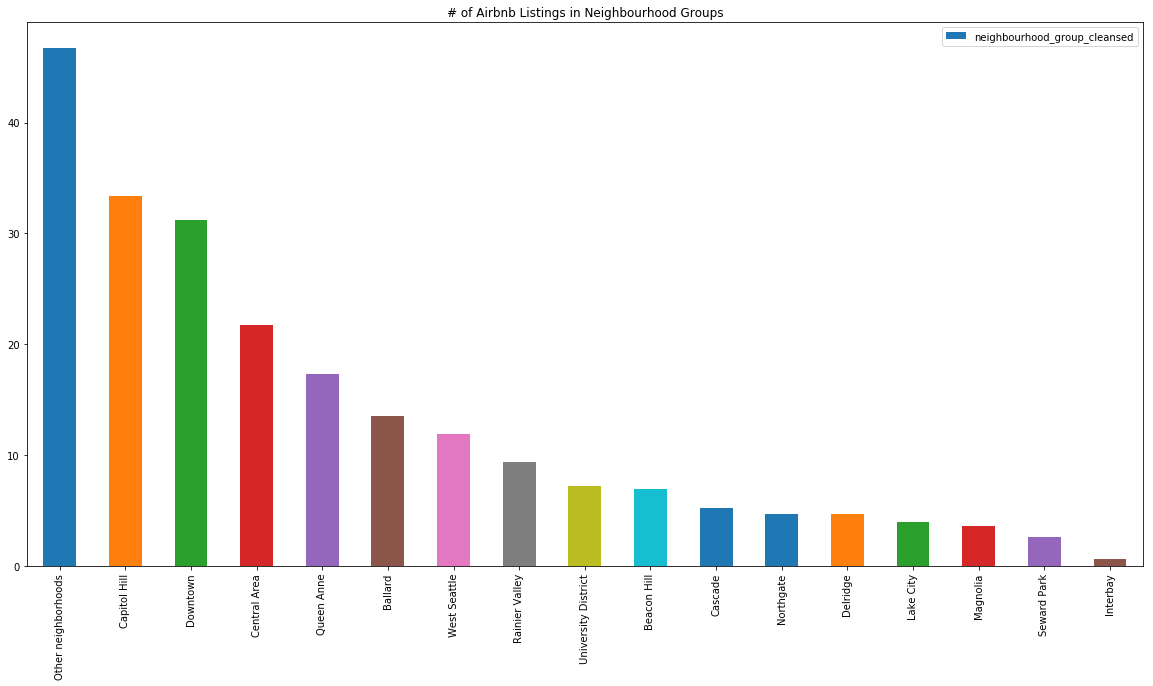

In [375]:
ngh_grp = airbnb_listing_df.neighbourhood_group_cleansed.value_counts().sort_values(ascending = False)
print(ngh_grp)

print(ngh_grp/ngh_grp.shape[0])

(ngh_grp/ngh_grp.shape[0]).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("# of Airbnb Listings in Neighbourhood Groups")

#### Understanding the Listing Data
###### List of neighbourhoods with highest Airbnb reviews in Seattle,WA

In [376]:
areas_and_reviews = airbnb_listing_df.groupby(by = ["number_of_reviews"])["neighbourhood_group_cleansed","neighbourhood_cleansed"].max()[::-1]
print(areas_and_reviews)


print(airbnb_listing_df.neighbourhood_group_cleansed.unique().tolist())


                  neighbourhood_group_cleansed     neighbourhood_cleansed
number_of_reviews                                                        
474                                   Downtown     International District
466                                   Downtown     International District
404                                    Ballard           Whittier Heights
353                               Capitol Hill                    Stevens
320                               Capitol Hill                   Montlake
319                                   Downtown  Central Business District
297                                   Delridge             South Delridge
294                               Capitol Hill                   Broadway
287                        Other neighborhoods                    Ravenna
279                               Capitol Hill                   Broadway
278                               Capitol Hill                   Broadway
277                                   

#### Number of Reviews in Neighbourhood Groups  

In [382]:
areas_and_reviews_2 = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["number_of_reviews"].sum()[::-1].sort_values(ascending = False)

neighbourhood_group_cleansed
Other neighborhoods    17210
Downtown               12606
Capitol Hill           12412
Central Area            8442
Ballard                 7118
Queen Anne              6613
Rainier Valley          4085
West Seattle            3407
Beacon Hill             3355
Delridge                2197
Cascade                 1420
Northgate               1389
University District     1316
Seward Park             1195
Lake City               1028
Magnolia                 933
Interbay                 123
Name: number_of_reviews, dtype: int64


Text(0.5, 1.0, '# of Airbnb Reviews in Seattle Neighbourhood Groups')

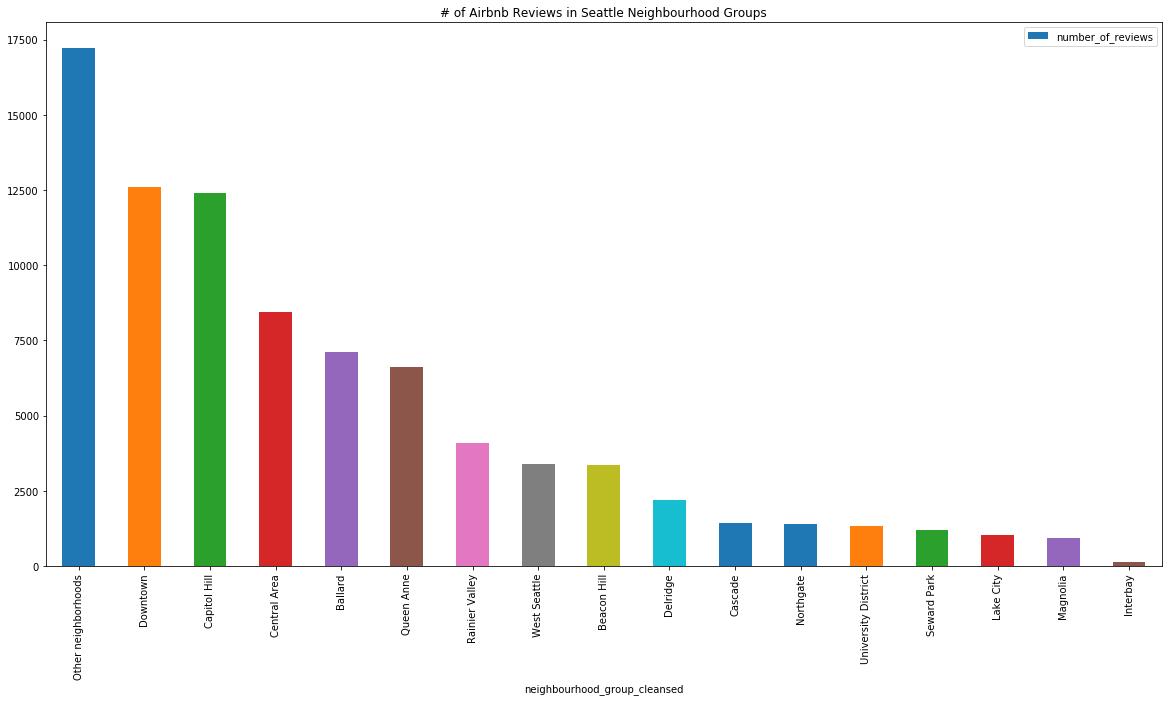

In [383]:
print(areas_and_reviews_2)

areas_and_reviews_2.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("# of Airbnb Reviews in Seattle Neighbourhood Groups")

#### Average Price of Airbnb Listing in Seattle Neighbourhood Groups

In [419]:
areas_and_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["price"].mean()[::-1].sort_values(ascending = False)

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Other neighborhoods    119.968514
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64


Text(0.5, 1.0, 'Average Price of Airbnb Listing in Seattle Neighbour Groups')

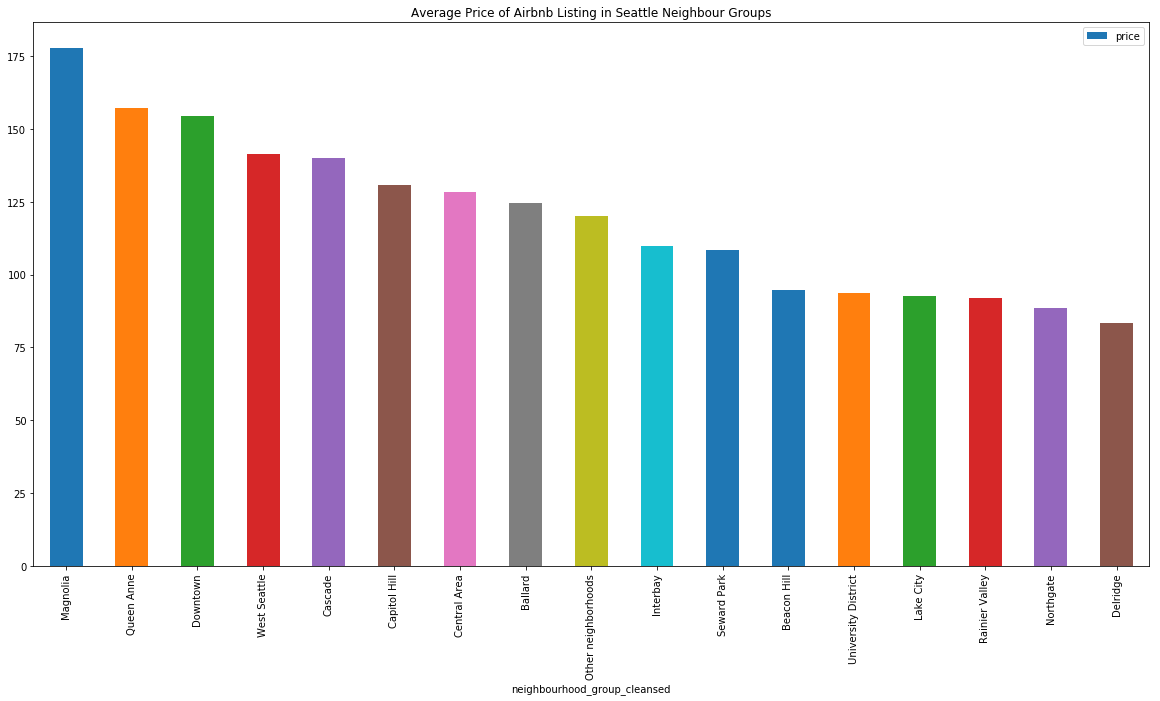

In [420]:
print(areas_and_prices)

areas_and_prices.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Airbnb Listing in Seattle Neighbour Groups")

#### Average Prices and Number of Reviews on Airbnb Listings in Seattle Neighbour Groups

In [80]:
price_and_review = pd.concat([areas_and_reviews_2,areas_and_prices], axis = 1, sort = True).sort_values(by="number_of_reviews", ascending =  False)

In [81]:
print(price_and_review)


                     number_of_reviews       price
Other neighborhoods              17210  119.968514
Downtown                         12606  154.405660
Capitol Hill                     12412  130.592593
Central Area                      8442  128.338753
Ballard                           7118  124.682609
Queen Anne                        6613  157.223729
Rainier Valley                    4085   91.899371
West Seattle                      3407  141.359606
Beacon Hill                       3355   94.669492
Delridge                          2197   83.278481
Cascade                           1420  140.101124
Northgate                         1389   88.550000
University District               1316   93.639344
Seward Park                       1195  108.477273
Lake City                         1028   92.671642
Magnolia                           933  177.672131
Interbay                           123  109.727273


#### Reviews per Month of different Neighbourhood Groups in Seattle


In [82]:
reviews_per_month = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["reviews_per_month"].sum()[::-1].sort_values(ascending = False)

In [83]:
reviews_per_month

neighbourhood_group_cleansed
Other neighborhoods    1206.58
Downtown               1074.36
Capitol Hill            929.07
Central Area            703.10
Queen Anne              532.57
Ballard                 496.15
Rainier Valley          332.17
West Seattle            305.10
Beacon Hill             250.52
University District     160.86
Delridge                141.85
Cascade                 117.33
Northgate               106.40
Seward Park             100.64
Lake City                86.51
Magnolia                 72.42
Interbay                 18.20
Name: reviews_per_month, dtype: float64

#### Finding the neighbourhoods associated with Other Neighbourhood Groups

In [84]:
neighbourhoods = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["neighbourhood_cleansed"]
#[airbnb_listing_df.neighbourhood_group == "Other neighborhoods"]

In [87]:
other_neighbourhood_list = []

for key, item in neighbourhoods:
    if key == "Other neighborhoods":
        print(key,item)
        other_neighborhoods = item
        other_neighbourhood_list.append(item.tolist())

Other neighborhoods 280     Wallingford
281     Wallingford
282     Wallingford
283     Wallingford
284     Wallingford
285     Wallingford
286     Wallingford
287     Wallingford
288     Wallingford
289     Wallingford
290     Wallingford
291     Wallingford
292     Wallingford
293     Wallingford
294     Wallingford
295     Wallingford
296     Wallingford
297     Wallingford
298     Wallingford
299     Wallingford
300     Wallingford
301     Wallingford
302     Wallingford
303     Wallingford
304     Wallingford
305     Wallingford
306     Wallingford
307     Wallingford
308     Wallingford
309     Wallingford
           ...     
3784        Fremont
3785        Fremont
3786        Fremont
3787        Fremont
3788        Fremont
3789        Fremont
3790        Fremont
3791        Fremont
3792        Fremont
3793        Fremont
3794        Fremont
3795        Fremont
3796        Fremont
3797        Fremont
3798        Fremont
3799        Fremont
3800        Fremont
3801        Fremont


##### List of the neighbourhoods in Seattle associated with Other Neighbourhood Groups

In [88]:
other_neighborhoods.unique().tolist()

['Wallingford',
 'Green Lake',
 'Crown Hill',
 'Industrial District',
 'Greenwood',
 'View Ridge',
 'Ravenna',
 'Bryant',
 'Roosevelt',
 'Wedgwood',
 'North Beach/Blue Ridge',
 'Bitter Lake',
 'Phinney Ridge',
 'Windermere',
 'Laurelhurst',
 'Georgetown',
 'South Park',
 'Broadview',
 'Fremont']

In [89]:
other_neighbourhood_set = set(other_neighbourhood_list[0])

other_neighbourhood_set

{'Bitter Lake',
 'Broadview',
 'Bryant',
 'Crown Hill',
 'Fremont',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Industrial District',
 'Laurelhurst',
 'North Beach/Blue Ridge',
 'Phinney Ridge',
 'Ravenna',
 'Roosevelt',
 'South Park',
 'View Ridge',
 'Wallingford',
 'Wedgwood',
 'Windermere'}

#### Number of Reviews in all the neighbourhoods in Seattle

In [90]:
areas_and_reviews_3 = airbnb_listing_df.groupby(by = ["neighbourhood_cleansed"])["number_of_reviews"].sum()[::-1].sort_values(ascending = False)

In [91]:
areas_and_reviews_3

neighbourhood_cleansed
Broadway                     8919
Belltown                     4686
Fremont                      4157
Wallingford                  4039
Minor                        3455
Central Business District    2526
First Hill                   2517
Stevens                      2436
North Beacon Hill            2356
West Woodland                2172
Lower Queen Anne             2050
West Queen Anne              1980
Columbia City                1965
Adams                        1948
Phinney Ridge                1634
Greenwood                    1620
East Queen Anne              1570
International District       1418
Mann                         1344
Ravenna                      1337
University District          1316
Whittier Heights             1308
Mount Baker                  1250
Seward Park                  1195
Green Lake                   1190
Atlantic                     1166
Eastlake                     1156
Loyal Heights                1096
North Queen Anne         

#### Number of Reviews in these neighbourhoods that make up Other Neighbourhood Group

In [92]:
areas_and_reviews_3.loc[other_neighbourhood_set]

neighbourhood_cleansed
View Ridge                  77
Broadview                  316
Ravenna                   1337
Bryant                     569
Windermere                  89
Greenwood                 1620
Laurelhurst                158
North Beach/Blue Ridge     131
Phinney Ridge             1634
South Park                  15
Fremont                   4157
Industrial District        146
Green Lake                1190
Georgetown                 286
Wedgwood                   286
Roosevelt                  369
Bitter Lake                134
Wallingford               4039
Crown Hill                 657
Name: number_of_reviews, dtype: int64

#### Prices of Airbnb in all the Neighbourhoods in Seattle

In [93]:
areas_and_prices_2 = airbnb_listing_df.groupby(by = ["neighbourhood_cleansed"])["price"].mean()[::-1].sort_values(ascending = False)

In [94]:
areas_and_prices_2

neighbourhood_cleansed
Southeast Magnolia           231.705882
Portage Bay                  227.857143
Westlake                     194.470588
West Queen Anne              187.769231
Montlake                     182.789474
Briarcliff                   176.571429
Sunset Hill                  176.055556
Industrial District          173.333333
Alki                         171.619048
Windermere                   169.900000
Pioneer Square               169.260870
Central Business District    164.213592
Fauntleroy                   164.100000
Belltown                     162.893162
East Queen Anne              159.414634
Madrona                      158.234043
Pike-Market                  157.785714
North Queen Anne             150.240741
Green Lake                   149.018519
Lawton Park                  147.566667
Holly Park                   147.166667
North Admiral                146.408163
View Ridge                   139.000000
Lower Queen Anne             138.202128
First Hill       

#### Prices of Airbnb in the Neighbourhoods that make up Other Neighbourhoods

In [95]:
areas_and_prices_2.loc[other_neighbourhood_set]

neighbourhood_cleansed
View Ridge                139.000000
Broadview                  94.705882
Ravenna                    88.686567
Bryant                    114.896552
Windermere                169.900000
Greenwood                  98.820225
Laurelhurst               108.400000
North Beach/Blue Ridge    128.285714
Phinney Ridge             129.520548
South Park                 90.000000
Fremont                   129.056962
Industrial District       173.333333
Green Lake                149.018519
Georgetown                 76.125000
Wedgwood                  110.444444
Roosevelt                 128.533333
Bitter Lake                83.000000
Wallingford               128.431138
Crown Hill                 87.666667
Name: price, dtype: float64

#### Dropping Other  Neighbourhoods and adding the individual neighbourhoods in that Group

#### Reviews

In [96]:
areas_and_reviews_cleaned = areas_and_reviews_2.copy(deep =True)

In [97]:

areas_and_reviews_cleaned.drop("Other neighborhoods", inplace = True)
areas_and_reviews_cleaned

neighbourhood_group_cleansed
Downtown               12606
Capitol Hill           12412
Central Area            8442
Ballard                 7118
Queen Anne              6613
Rainier Valley          4085
West Seattle            3407
Beacon Hill             3355
Delridge                2197
Cascade                 1420
Northgate               1389
University District     1316
Seward Park             1195
Lake City               1028
Magnolia                 933
Interbay                 123
Name: number_of_reviews, dtype: int64

In [98]:
areas_and_reviews_cleaned = areas_and_reviews_cleaned.append(areas_and_reviews_3.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [99]:
areas_and_reviews_cleaned

Downtown                  12606
Capitol Hill              12412
Central Area               8442
Ballard                    7118
Queen Anne                 6613
Fremont                    4157
Rainier Valley             4085
Wallingford                4039
West Seattle               3407
Beacon Hill                3355
Delridge                   2197
Phinney Ridge              1634
Greenwood                  1620
Cascade                    1420
Northgate                  1389
Ravenna                    1337
University District        1316
Seward Park                1195
Green Lake                 1190
Lake City                  1028
Magnolia                    933
Crown Hill                  657
Bryant                      569
Roosevelt                   369
Broadview                   316
Georgetown                  286
Wedgwood                    286
Laurelhurst                 158
Industrial District         146
Bitter Lake                 134
North Beach/Blue Ridge      131
Interbay

#### Prices 

In [340]:
areas_and_prices_cleaned = areas_and_prices.copy(deep =True)

NameError: name 'areas_and_prices' is not defined

In [101]:
areas_and_prices_cleaned.drop("Other neighborhoods", inplace = True)

In [102]:
areas_and_prices_cleaned

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64

In [339]:
areas_and_prices_cleaned = areas_and_prices_cleaned.append(areas_and_prices_2.loc[other_neighbourhood_set]).sort_values(ascending = False)

NameError: name 'areas_and_prices_cleaned' is not defined

In [104]:
areas_and_prices_cleaned 

Magnolia                  177.672131
Industrial District       173.333333
Windermere                169.900000
Queen Anne                157.223729
Downtown                  154.405660
Green Lake                149.018519
West Seattle              141.359606
Cascade                   140.101124
View Ridge                139.000000
Capitol Hill              130.592593
Phinney Ridge             129.520548
Fremont                   129.056962
Roosevelt                 128.533333
Wallingford               128.431138
Central Area              128.338753
North Beach/Blue Ridge    128.285714
Ballard                   124.682609
Bryant                    114.896552
Wedgwood                  110.444444
Interbay                  109.727273
Seward Park               108.477273
Laurelhurst               108.400000
Greenwood                  98.820225
Broadview                  94.705882
Beacon Hill                94.669492
University District        93.639344
Lake City                  92.671642
R

#### Number of Reviews Per Month in all the neighbourhoods in Seattle

In [105]:
reviews_per_month_2 = airbnb_listing_df.groupby(by = ["neighbourhood_cleansed"])["reviews_per_month"].sum()[::-1].sort_values(ascending = False)

In [106]:
reviews_per_month_2

neighbourhood_cleansed
Broadway                     676.88
Belltown                     403.18
Fremont                      286.17
Minor                        281.07
Wallingford                  239.90
First Hill                   220.78
Central Business District    207.65
Lower Queen Anne             170.61
Stevens                      168.25
University District          160.86
North Beacon Hill            155.70
East Queen Anne              151.33
West Woodland                150.14
Adams                        145.39
Columbia City                135.14
Phinney Ridge                130.04
West Queen Anne              120.33
Mann                         115.67
Greenwood                    115.33
Ravenna                      104.37
Seward Park                  100.64
Loyal Heights                 99.56
Atlantic                      98.07
Leschi                        95.55
Mount Baker                   91.24
North Queen Anne              90.30
Mid-Beacon Hill               84.54
Pike-

#### Reviews Per Month in these neighbourhoods that make up Other Neighbourhood Group

In [107]:
reviews_per_month_2.loc[other_neighbourhood_set]

neighbourhood_cleansed
View Ridge                  9.72
Broadview                  29.93
Ravenna                   104.37
Bryant                     35.60
Windermere                  8.83
Greenwood                 115.33
Laurelhurst                16.73
North Beach/Blue Ridge     20.89
Phinney Ridge             130.04
South Park                  1.25
Fremont                   286.17
Industrial District         6.07
Green Lake                 70.12
Georgetown                 19.69
Wedgwood                   20.30
Roosevelt                  33.30
Bitter Lake                19.43
Wallingford               239.90
Crown Hill                 38.91
Name: reviews_per_month, dtype: float64

#### Dropping Other Neighbourhoods and adding the individual neighbourhoods in that Group

In [108]:
reviews_per_month_cleaned = reviews_per_month.copy(deep =True)

In [109]:
reviews_per_month_cleaned.drop("Other neighborhoods", inplace = True)

In [110]:
reviews_per_month_cleaned

neighbourhood_group_cleansed
Downtown               1074.36
Capitol Hill            929.07
Central Area            703.10
Queen Anne              532.57
Ballard                 496.15
Rainier Valley          332.17
West Seattle            305.10
Beacon Hill             250.52
University District     160.86
Delridge                141.85
Cascade                 117.33
Northgate               106.40
Seward Park             100.64
Lake City                86.51
Magnolia                 72.42
Interbay                 18.20
Name: reviews_per_month, dtype: float64

In [111]:
reviews_per_month_cleaned = reviews_per_month_cleaned.append(reviews_per_month_2.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [52]:
reviews_per_month_cleaned

Downtown                  2689.21
Capitol Hill              2499.18
Central Area              2102.11
Queen Anne                1458.07
Ballard                   1167.25
West Seattle              1050.06
Rainier Valley             985.72
Beacon Hill                891.24
Wallingford                667.72
Fremont                    662.71
Delridge                   597.68
Cascade                    530.29
Northgate                  443.68
Greenwood                  405.51
Magnolia                   360.19
University District        307.75
Phinney Ridge              285.21
Lake City                  283.34
Green Lake                 279.99
Ravenna                    197.86
Seward Park                166.93
Roosevelt                  165.25
Bryant                      90.39
Crown Hill                  90.25
Broadview                   84.16
Georgetown                  82.34
Bitter Lake                 74.43
Interbay                    58.38
Wedgwood                    57.87
North Beach/Bl

#### Revised Reviews of Neighbourhood Groups and Prices of Airbnb in Seattle

#### Total Reviews

Text(0.5,1,'# of Airbnb Reviews in Revised Seattle Neighbourhood Groups')

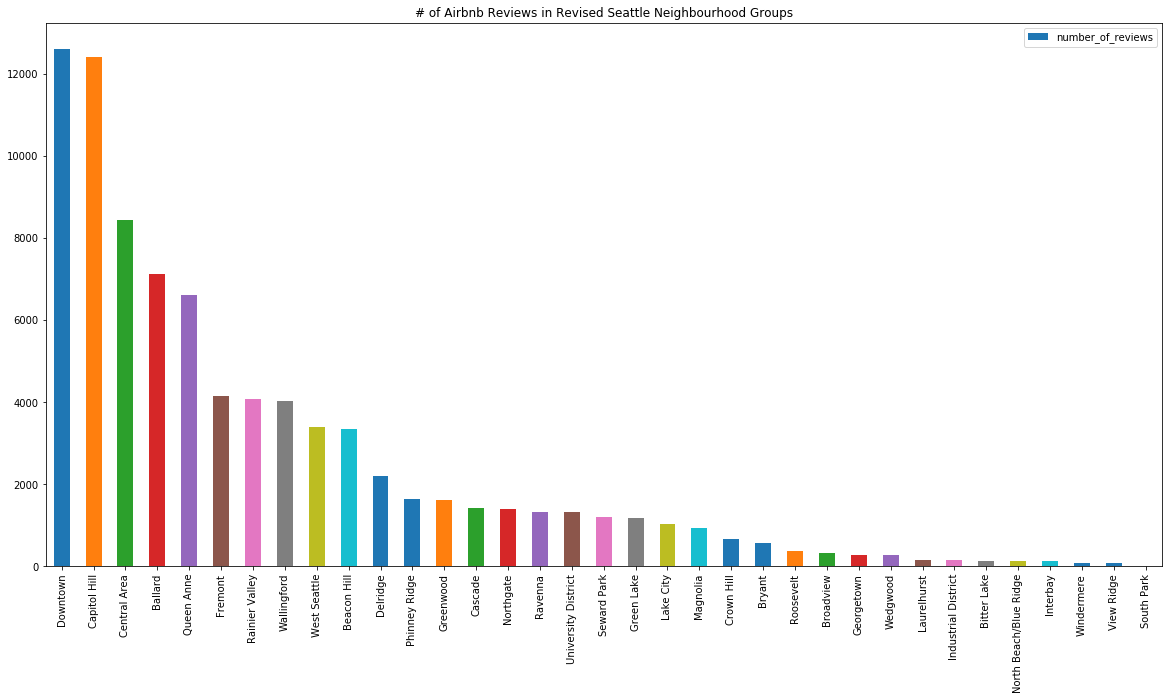

In [112]:
areas_and_reviews_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)

plt.title("# of Airbnb Reviews in Revised Seattle Neighbourhood Groups")


#### Reviews Per Month

Text(0.5,1,'Reviews Per Month of Revised Airbnb Listing in Seattle Neighbourhood Groups')

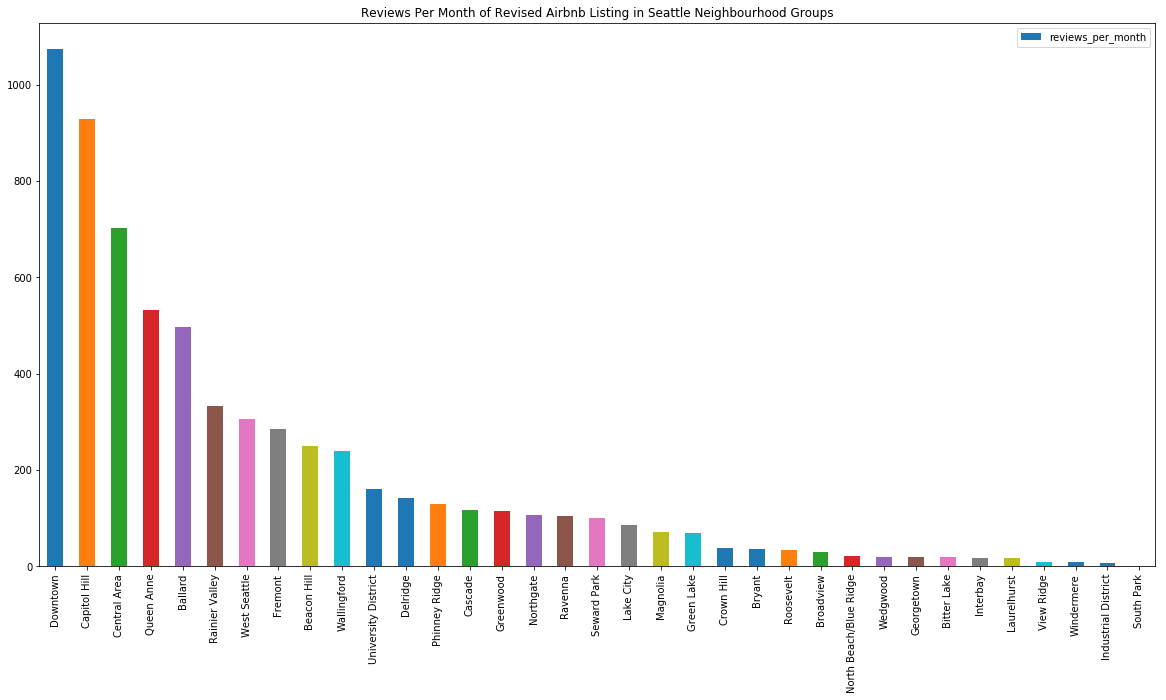

In [113]:
reviews_per_month_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Reviews Per Month of Revised Airbnb Listing in Seattle Neighbourhood Groups")

#### Airbnb Prices

Text(0.5,1,'Average Price of Revised Airbnb Listing in Seattle Neighbourhood Groups')

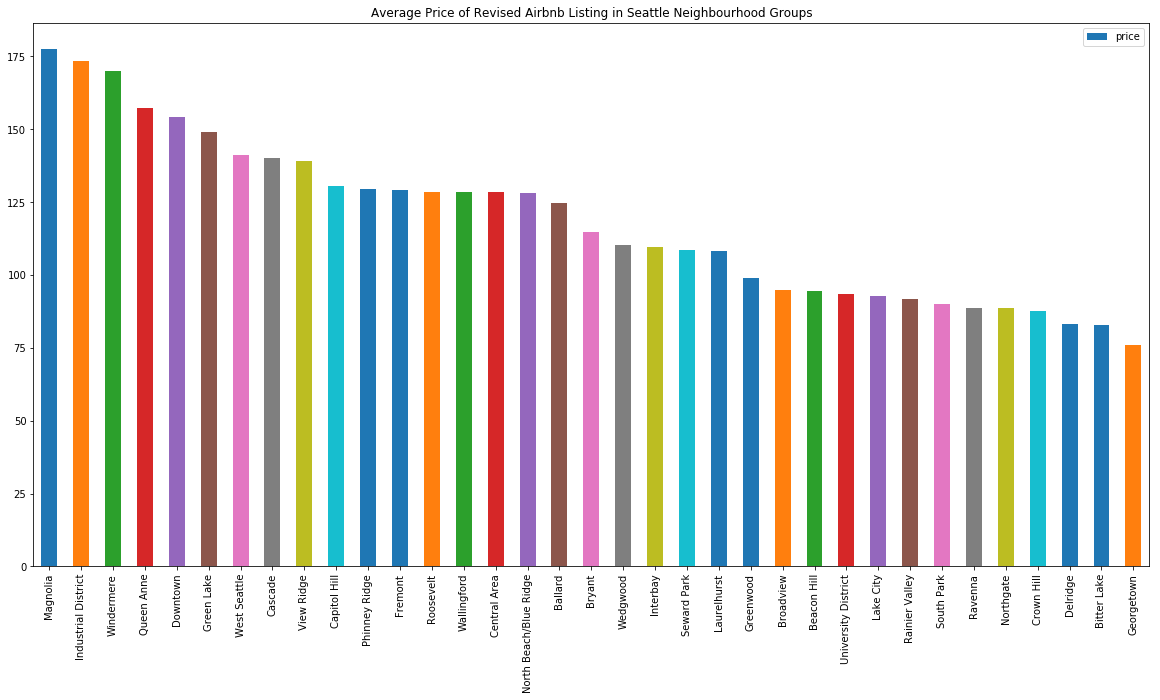

In [114]:
areas_and_prices_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Revised Airbnb Listing in Seattle Neighbourhood Groups")

#### Airbnb Prices of the Highest Visited Neighbourhood Groups in Seattle

In [338]:
areas_and_prices_cleaned.where(areas_and_reviews_cleaned > 3000).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Revised Airbnb Listing in Seattle Neighbourhoods with atleast 3,000 Reviews")

NameError: name 'areas_and_prices_cleaned' is not defined

##### Prices are higher in the most reviewed neighborhoods

##### Business Question:
##### How does number of reviews drive the Airbnb Prices in Seattle?

##### We are going to monitor standard deviation of Airbnb Prices in different Neighbour Groups to analyze how stable prices are in popular neighbourhood groups 

In [118]:
areas_and_prices_3_std = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["price"].std()[::-1].sort_values(ascending = False)

In [119]:
areas_and_prices_3_std

neighbourhood_group_cleansed
Magnolia               150.078726
Queen Anne             115.863385
Cascade                112.179042
Capitol Hill            92.442331
Downtown                90.902800
West Seattle            89.147801
Ballard                 87.925033
Other neighborhoods     86.580450
Central Area            80.260558
Seward Park             71.718276
Beacon Hill             61.528682
Interbay                60.003485
University District     59.721816
Lake City               57.212625
Rainier Valley          52.505599
Delridge                41.797110
Northgate               38.642110
Name: price, dtype: float64

In [120]:
areas_and_prices_4_std = airbnb_listing_df.groupby(by = ["neighbourhood_cleansed"])["price"].std()[::-1].sort_values(ascending = False)

In [121]:
areas_and_prices_4_std.loc[other_neighbourhood_set]

neighbourhood_cleansed
View Ridge                 60.470378
Broadview                  46.747680
Ravenna                    55.727206
Bryant                     68.180090
Windermere                104.919493
Greenwood                  60.966191
Laurelhurst                49.855792
North Beach/Blue Ridge     70.827449
Phinney Ridge              78.421955
South Park                 21.794495
Fremont                    80.948615
Industrial District       104.769588
Green Lake                103.951275
Georgetown                 15.994977
Wedgwood                   72.891718
Roosevelt                 169.039219
Bitter Lake                47.448217
Wallingford                99.054779
Crown Hill                 54.487002
Name: price, dtype: float64

In [122]:
areas_and_prices_std_cleaned = areas_and_prices_3_std.copy(deep =True)

In [123]:
areas_and_prices_std_cleaned.drop("Other neighborhoods", inplace = True)

In [124]:
areas_and_prices_std_cleaned

neighbourhood_group_cleansed
Magnolia               150.078726
Queen Anne             115.863385
Cascade                112.179042
Capitol Hill            92.442331
Downtown                90.902800
West Seattle            89.147801
Ballard                 87.925033
Central Area            80.260558
Seward Park             71.718276
Beacon Hill             61.528682
Interbay                60.003485
University District     59.721816
Lake City               57.212625
Rainier Valley          52.505599
Delridge                41.797110
Northgate               38.642110
Name: price, dtype: float64

In [125]:
areas_and_prices_std_cleaned = areas_and_prices_std_cleaned.append(areas_and_prices_4_std.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [126]:
areas_and_prices_std_cleaned

Roosevelt                 169.039219
Magnolia                  150.078726
Queen Anne                115.863385
Cascade                   112.179042
Windermere                104.919493
Industrial District       104.769588
Green Lake                103.951275
Wallingford                99.054779
Capitol Hill               92.442331
Downtown                   90.902800
West Seattle               89.147801
Ballard                    87.925033
Fremont                    80.948615
Central Area               80.260558
Phinney Ridge              78.421955
Wedgwood                   72.891718
Seward Park                71.718276
North Beach/Blue Ridge     70.827449
Bryant                     68.180090
Beacon Hill                61.528682
Greenwood                  60.966191
View Ridge                 60.470378
Interbay                   60.003485
University District        59.721816
Lake City                  57.212625
Ravenna                    55.727206
Crown Hill                 54.487002
R

Text(0.5,1,'STD of Prices of Revised Airbnb Listing in Seattle Neighbourhood Groups')

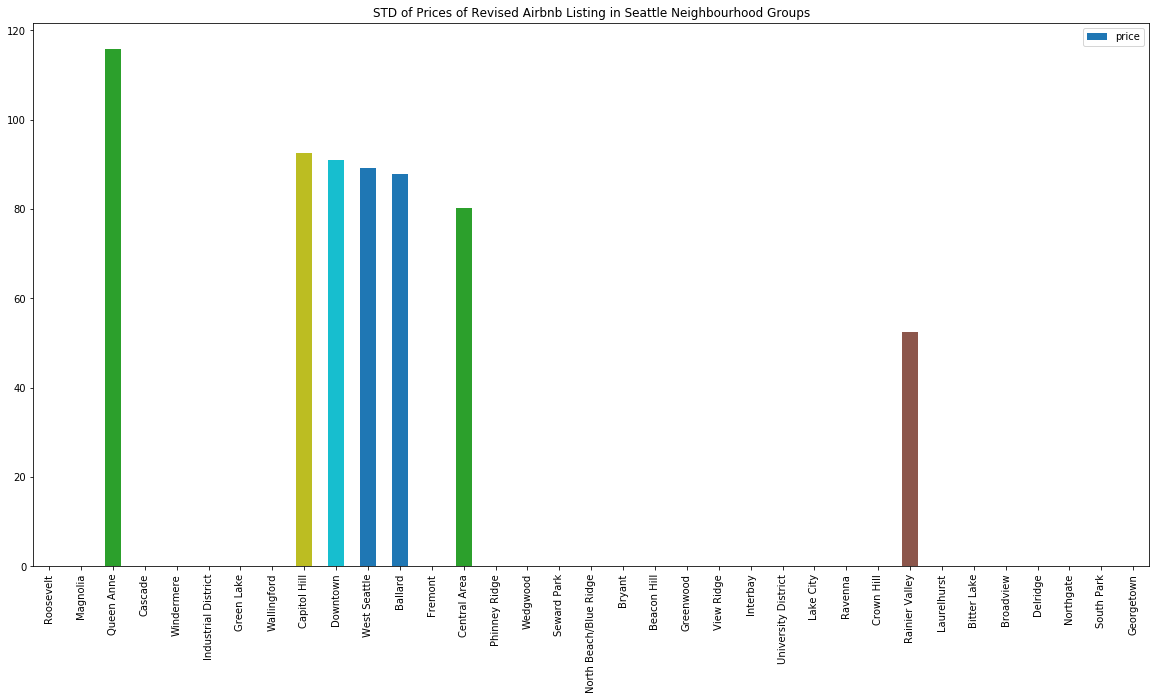

In [128]:
areas_and_prices_std_cleaned.where(reviews_per_month_cleaned > 300).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("STD of Prices of Revised Airbnb Listing in Seattle Neighbourhood Groups")

###### Airbnb host have are most comptitive in Queen Anne , since the price variations is highest here.

Queen Anne has high land  
This is just an initial hypothesis for high variation in prices or it is u just a high completive neighbour group since it is slightly off centered from the Downtown and host have to be very competitive in prices. 

In [129]:
max_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["price"].quantile(q = .95, interpolation = 'linear')[::-1].sort_values(ascending = False)

In [130]:
max_prices

neighbourhood_group_cleansed
Magnolia               375.00
Queen Anne             363.50
Ballard                350.00
West Seattle           325.00
Downtown               300.00
Central Area           295.00
Capitol Hill           295.00
Other neighborhoods    280.00
Cascade                280.00
Seward Park            250.00
University District    250.00
Lake City              247.00
Beacon Hill            201.40
Interbay               200.00
Rainier Valley         199.00
Northgate              151.95
Delridge               148.20
Name: price, dtype: float64

In [131]:
mid_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["price"].quantile(q = .5, interpolation = 'linear')[::-1].sort_values(ascending = False)

In [132]:
mid_prices

neighbourhood_group_cleansed
Downtown               139.0
Magnolia               129.0
Queen Anne             119.0
Cascade                115.0
West Seattle           109.0
Capitol Hill           105.0
Central Area           100.0
Other neighborhoods     99.0
Ballard                 95.0
Seward Park             93.0
Interbay                90.0
University District     85.0
Rainier Valley          80.0
Northgate               79.5
Beacon Hill             75.0
Delridge                72.0
Lake City               70.0
Name: price, dtype: float64

###### After analyzing the data. 

Downtown, Queen Anne is stable and completitive.
Price variation in Magnolia is high and tallies with its standard deviation.
 

#### Analysis 

In [133]:
airbnb_listing_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


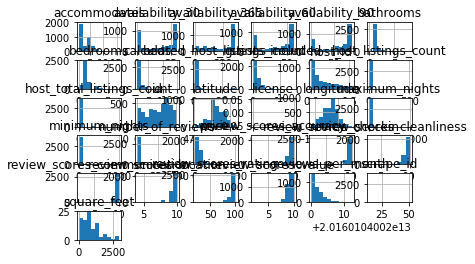

In [134]:
airbnb_listing_df.hist();

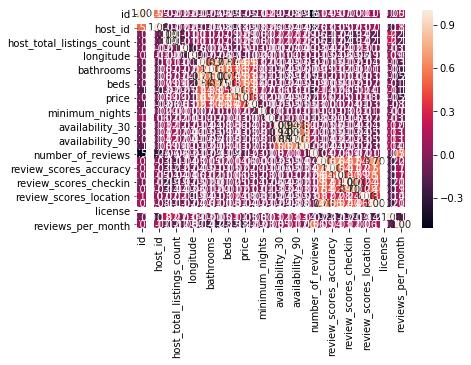

In [139]:
sns.heatmap(airbnb_listing_df.corr(), annot = True, fmt = '.2f')

In [211]:
airbnb_listing_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [212]:
features_raw = airbnb_listing_df.drop(columns= ["license","square_feet","notes","neighborhood_overview","transit","host_about"])

#### Removing Missing Values & Cleaning Dataing

In [213]:
features_raw.isnull().sum().sort_values(ascending = False)

monthly_price                     2301
security_deposit                  1952
weekly_price                      1809
cleaning_fee                      1030
host_acceptance_rate               773
review_scores_checkin              658
review_scores_accuracy             658
review_scores_value                656
review_scores_location             655
review_scores_cleanliness          653
review_scores_communication        651
review_scores_rating               647
first_review                       627
last_review                        627
reviews_per_month                  627
space                              569
host_response_rate                 523
host_response_time                 523
neighbourhood                      416
thumbnail_url                      320
medium_url                         320
xl_picture_url                     320
host_neighbourhood                 300
summary                            177
bathrooms                           16
host_location            

In [214]:
print(features_raw.monthly_price.iloc[67])
#pd.concat(features_raw.monthly_price.str[1:],features_raw.monthly_price.str[3:])

#features_raw.monthly_price = pd.to_numeric(features_raw.monthly_price.str[1:2] + features_raw.monthly_price.str[3:], errors = "raise")
#airbnb_listing_df.price = pd.to_numeric(airbnb_listing_df.price.str[1:], errors = "raise")


for i,monthly_price in enumerate(features_raw.monthly_price):
    if type(monthly_price) == str and len(monthly_price) >= 10:
        features_raw.monthly_price[i] = pd.to_numeric(features_raw.monthly_price[i][1:3] + features_raw.monthly_price[i][4:], errors = "raise") 
    if type(monthly_price) == str and len(monthly_price) <10 and len(monthly_price) >= 9:
        features_raw.monthly_price[i] = pd.to_numeric(features_raw.monthly_price[i][1:2] + features_raw.monthly_price[i][3:], errors = "raise") 
        #print(features_raw.security_deposit[i])
    if type(monthly_price) == str and len(monthly_price) < 9:
         features_raw.monthly_price[i] = pd.to_numeric(features_raw.monthly_price[i][1:], errors = "raise") 


$12,140.00


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Cleaning Monthly Price

In [215]:
features_raw.monthly_price.iloc[67]

12140.0

In [216]:
features_raw.monthly_price.fillna(0, inplace = True)

#### Cleaning Security Deposit

In [217]:
features_raw.security_deposit.fillna(0.00, inplace = True)

In [218]:


for i,deposit in enumerate(features_raw.security_deposit):
    if type(deposit) == str and len(deposit) >= 9:
        features_raw.security_deposit[i] = pd.to_numeric(features_raw.security_deposit[i][1:2] + features_raw.security_deposit[i][3:], errors = "raise") 
        #print(features_raw.security_deposit[i])
    if type(deposit) == str and len(deposit) < 9:
         features_raw.security_deposit[i] = pd.to_numeric(features_raw.security_deposit[i][1:], errors = "raise") 



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [219]:
features_raw.security_deposit.head()

0       0
1     100
2    1000
3       0
4     700
Name: security_deposit, dtype: object

#### Cleaning Weekly Price

In [220]:
features_raw.weekly_price.head()

0          NaN
1    $1,000.00
2          NaN
3      $650.00
4          NaN
Name: weekly_price, dtype: object

In [221]:
for i,weekly in enumerate(features_raw.weekly_price):
    if type(weekly) == str and len(weekly) >= 9:
        features_raw.weekly_price[i] = pd.to_numeric(features_raw.weekly_price[i][1:2] + features_raw.weekly_price[i][3:], errors = "raise") 
        #print(features_raw.weekly_price[i])
    if type(weekly) == str and len(weekly) < 9:
         features_raw.weekly_price[i] = pd.to_numeric(features_raw.weekly_price[i][1:], errors = "raise") 



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [222]:
features_raw.weekly_price.head()

0     NaN
1    1000
2     NaN
3     650
4     NaN
Name: weekly_price, dtype: object

In [223]:
features_raw.weekly_price.fillna(0, inplace = True)

In [224]:
features_raw.weekly_price.head()

0       0.0
1    1000.0
2       0.0
3     650.0
4       0.0
Name: weekly_price, dtype: float64

#### Cleaning Cleaning Fee

In [225]:
features_raw.cleaning_fee.head()

0        NaN
1     $40.00
2    $300.00
3        NaN
4    $125.00
Name: cleaning_fee, dtype: object

In [226]:
features_raw.cleaning_fee = pd.to_numeric(features_raw.cleaning_fee.str[1:], errors = "raise") 

In [227]:
features_raw.cleaning_fee.fillna(0, inplace = True)
features_raw.cleaning_fee.head()


0      0.0
1     40.0
2    300.0
3      0.0
4    125.0
Name: cleaning_fee, dtype: float64

#### Cleaning Host Acceptance Rate

In [228]:
features_raw.host_acceptance_rate.fillna(0,inplace = True)

features_raw.host_acceptance_rate.head()

0    100%
1    100%
2    100%
3       0
4       0
Name: host_acceptance_rate, dtype: object

In [229]:
len(features_raw.host_acceptance_rate[0])

features_raw.host_acceptance_rate = pd.to_numeric(features_raw.host_acceptance_rate.str[:-1], errors = "raise") 

In [230]:
features_raw.host_acceptance_rate.fillna(0,inplace = True)
features_raw.host_acceptance_rate.head()

0    100.0
1    100.0
2    100.0
3      0.0
4      0.0
Name: host_acceptance_rate, dtype: float64

In [231]:
features_not_null = features_raw.isnull().sum().sort_values(ascending = False).index.tolist()

In [232]:
features_raw = features_raw[features_not_null].dropna(how = "any")


In [233]:
features_raw.head()

,review_scores_accuracy,review_scores_checkin,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_communication,review_scores_rating,first_review,last_review,reviews_per_month,...,room_type,bed_type,guests_included,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,id
1,10.0,10.0,10.0,10.0,10.0,10.0,96.0,2013-08-19,2015-12-29,1.48,...,Entire home/apt,Real Bed,1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150,1000.0,3000.0,100,40.0,953595
6,10.0,10.0,10.0,10.0,10.0,10.0,99.0,2014-01-27,2015-12-07,2.46,...,Private room,Real Bed,1,"{""Wireless Internet"",""Free Parking on Premises...",80,575.0,0.0,150,0.0,1909058
7,10.0,10.0,10.0,9.0,10.0,10.0,97.0,2013-01-03,2016-01-01,4.73,...,Private room,Real Bed,1,"{""Wireless Internet"",""Pets live on this proper...",60,360.0,0.0,150,25.0,856550
9,10.0,10.0,9.0,10.0,10.0,10.0,97.0,2014-04-27,2015-12-20,1.55,...,Entire home/apt,Real Bed,1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150,1000.0,3000.0,100,40.0,2493658
10,10.0,10.0,10.0,10.0,10.0,10.0,97.0,2011-07-21,2015-11-25,3.33,...,Entire home/apt,Real Bed,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",95,595.0,0.0,0,15.0,175576


#### Finding missing values

In [234]:
features_raw.isnull().sum().sort_values(ascending = False)

id                               0
host_thumbnail_url               0
host_name                        0
host_picture_url                 0
host_identity_verified           0
host_has_profile_pic             0
host_since                       0
host_total_listings_count        0
host_listings_count              0
host_is_superhost                0
property_type                    0
zipcode                          0
beds                             0
last_scraped                     0
host_acceptance_rate             0
host_id                          0
name                             0
scrape_id                        0
description                      0
host_verifications               0
bedrooms                         0
host_location                    0
cleaning_fee                     0
reviews_per_month                0
review_scores_checkin            0
review_scores_value              0
review_scores_location           0
review_scores_cleanliness        0
review_scores_commun

In [235]:
features_raw.shape

(2006, 86)

#### Cleaning the data

In [236]:
features = ['id','host_id','host_response_time',
             'host_response_rate','host_acceptance_rate','host_is_superhost',
            'host_listings_count','host_total_listings_count',
             'host_has_profile_pic','host_identity_verified','neighbourhood_cleansed',
             'neighbourhood_group_cleansed','zipcode','latitude','longitude',
             'is_location_exact','property_type','room_type','accommodates',
            'bathrooms','bedrooms','beds','bed_type','amenities',
             'weekly_price','monthly_price','security_deposit','cleaning_fee','guests_included',
             'extra_people','minimum_nights','maximum_nights','calendar_updated',
             'has_availability','availability_30','availability_60','availability_90','availability_365',
             'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
             'review_scores_checkin','review_scores_communication','review_scores_location',
             'review_scores_value','requires_license','jurisdiction_names','instant_bookable',
             'cancellation_policy','require_guest_profile_picture',
             'require_guest_phone_verification','reviews_per_month']

features_raw.columns.tolist()

['review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_value',
 'review_scores_location',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_rating',
 'first_review',
 'last_review',
 'reviews_per_month',
 'space',
 'host_response_rate',
 'host_response_time',
 'neighbourhood',
 'xl_picture_url',
 'thumbnail_url',
 'medium_url',
 'host_neighbourhood',
 'summary',
 'bathrooms',
 'host_location',
 'zipcode',
 'bedrooms',
 'host_name',
 'host_picture_url',
 'host_identity_verified',
 'host_has_profile_pic',
 'host_since',
 'host_total_listings_count',
 'host_listings_count',
 'host_is_superhost',
 'host_thumbnail_url',
 'property_type',
 'beds',
 'last_scraped',
 'host_acceptance_rate',
 'host_id',
 'name',
 'scrape_id',
 'description',
 'host_verifications',
 'experiences_offered',
 'state',
 'host_url',
 'street',
 'listing_url',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'picture_url',
 'longitude',
 'market',
 'calend

In [237]:
features_raw = features_raw[features]

In [238]:
features_raw.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
1,953595,5177328,within an hour,98%,100.0,t,6.0,6.0,t,t,...,10.0,10.0,10.0,f,WASHINGTON,f,strict,t,t,1.48
6,1909058,2497928,within an hour,100%,100.0,t,1.0,1.0,t,t,...,10.0,10.0,10.0,f,WASHINGTON,f,moderate,f,f,2.46
7,856550,4016632,within an hour,100%,100.0,t,5.0,5.0,t,t,...,10.0,9.0,10.0,f,WASHINGTON,f,strict,t,t,4.73
9,2493658,5177328,within an hour,98%,100.0,t,6.0,6.0,t,t,...,10.0,10.0,9.0,f,WASHINGTON,f,strict,t,t,1.55
10,175576,239585,within a few hours,100%,100.0,t,1.0,1.0,t,t,...,10.0,10.0,10.0,f,WASHINGTON,f,moderate,t,f,3.33


In [239]:
print(airbnb_listing_df.shape)
print(features_raw.shape)

(3818, 92)
(2006, 53)


##### Cleaning and Preparing Price 

In [240]:
price_raw = airbnb_listing_df.price

In [241]:
price_raw.head()

0     85
1    150
2    975
3    100
4    450
Name: price, dtype: object

In [242]:


for i,price in enumerate(price_raw):
    if type(price) == str and len(price) >= 9:
        price_raw[i] = pd.to_numeric(price_raw[i][1:2] + price_raw[i][3:], errors = "raise") 
        #print(features_raw.security_deposit[i])
    if type(price) == str and len(price) < 9:
         price_raw[i] = pd.to_numeric(price_raw[i][1:], errors = "raise") 

In [243]:
price_raw.head()

0     85
1    150
2    975
3    100
4    450
Name: price, dtype: object

#### Cleaning Host Response Rate

In [244]:
features_raw.host_response_rate = pd.to_numeric(features_raw.host_response_rate.str[:-1], errors = "raise")
features_raw.host_response_rate.fillna(0, inplace = True)
features_raw.host_response_rate.head()

1      98
6     100
7     100
9      98
10    100
Name: host_response_rate, dtype: int64

In [245]:
features_raw.host_response_time.head()

1         within an hour
6         within an hour
7         within an hour
9         within an hour
10    within a few hours
Name: host_response_time, dtype: object

#### Cleaning Security Deposit

In [246]:
features_raw.security_deposit.head()

1     100
6     150
7     150
9     100
10      0
Name: security_deposit, dtype: object

In [247]:
features_raw.security_deposit = pd.to_numeric(features_raw.security_deposit, errors = "raise") 

In [248]:
features_raw.security_deposit.head()

1     100.0
6     150.0
7     150.0
9     100.0
10      0.0
Name: security_deposit, dtype: float64

#### Cleaning Extra people 

In [249]:
#print(features_raw.extra_people.iloc[0])

features_raw.extra_people = pd.to_numeric(features_raw.extra_people.str[1:], errors = "raise")

In [250]:
features_raw.extra_people.head()

1      0.0
6     10.0
7      0.0
9      0.0
10    15.0
Name: extra_people, dtype: float64

#### Cleaning Aminities

In [251]:
features_raw.amenities.fillna("N/A")

1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
6       {"Wireless Internet","Free Parking on Premises...
7       {"Wireless Internet","Pets live on this proper...
9       {TV,Internet,"Wireless Internet",Kitchen,"Free...
10      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
11      {TV,"Cable TV","Wireless Internet",Kitchen,"Fr...
13      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
14      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
16      {Internet,"Wireless Internet","Pets Allowed",B...
17      {"Wireless Internet","Free Parking on Premises...
21      {"Cable TV",Internet,"Wireless Internet","Free...
27      {"Wireless Internet","Pets live on this proper...
29      {TV,"Cable TV","Wireless Internet","Wheelchair...
30      {TV,Internet,"Wireless Internet",Kitchen,"Free...
31      {TV,Internet,"Wireless Internet",Kitchen,"Free...
33      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
35      {TV,"Cable TV",Internet,"Wireless Internet","A...
37      {TV,In

In [252]:
amenities_list = []

for amenity in (features_raw.amenities):
    amenities_list.append([amenity.replace("{","").replace("}","").replace('"','').split(",")])

In [253]:
amenity_set = []
for amenities in amenities_list:
    for amenity in amenities[0]:
        amenity_set.append(amenity)
    

In [254]:
amenity_names = list(set(amenity_set))


In [255]:
"amenities " + amenities_list [0][0][0]

'amenities TV'

#### Hot Encoding Amentities

In [256]:
features_raw_processed = features_raw.copy(deep = True)

In [257]:
zeros_array = np.zeros(len(features_raw_processed))

amenity_names_list = []
for amenity_name in amenity_names:
    amenity_names_list.append("amenities " + amenity_name) 
    names = "amenities " + amenity_name
    features_raw_processed[names] = pd.Series(zeros_array, index = features_raw_processed.index)

In [258]:
features_raw_processed.columns.tolist()

['id',
 'host_id',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'zipcode',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',


In [259]:
amenity_total_score = []
amenity_score = []

for amenities in amenities_list:
    amenity_score = []
    for amenity_name in amenity_names:
        score = []
        for amenity in amenities[0]:
            if amenity == amenity_name:
                score.append(1)
            #else:
                #score.append(0)
        if len(score) < 1:
            score.append(0)
        amenity_score.append(score[0])
        
    amenity_total_score.append(amenity_score)

In [260]:
print(len(amenity_total_score))

amenity_total_score[0]



2006


[0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1]

In [261]:
features_raw_processed_2 = pd.DataFrame(data = amenity_total_score,columns = amenity_names_list,  index = features_raw_processed.index)

In [262]:
features_raw_processed_2.head()

,amenities,amenities Smoke Detector,amenities 24-Hour Check-in,amenities Lock on Bedroom Door,amenities Smoking Allowed,amenities Hot Tub,amenities Dryer,amenities Free Parking on Premises,amenities Cable TV,amenities Dog(s),...,amenities Family/Kid Friendly,amenities Breakfast,amenities Kitchen,amenities Other pet(s),amenities Laptop Friendly Workspace,amenities Internet,amenities Wheelchair Accessible,amenities Gym,amenities Iron,amenities Safety Card
1,0,1,0,0,0,0,1,1,0,0,...,1,0,1,0,0,1,0,0,0,1
6,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,1,1,0,0,...,1,0,1,0,0,1,0,0,0,1
10,0,1,1,0,0,0,1,1,1,0,...,0,0,1,0,1,1,0,0,1,1


In [263]:
features_raw = pd.concat([features_raw, features_raw_processed_2], axis=1, sort=False)

In [264]:
features_raw.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,amenities Family/Kid Friendly,amenities Breakfast,amenities Kitchen,amenities Other pet(s),amenities Laptop Friendly Workspace,amenities Internet,amenities Wheelchair Accessible,amenities Gym,amenities Iron,amenities Safety Card
1,953595,5177328,within an hour,98,100.0,t,6.0,6.0,t,t,...,1,0,1,0,0,1,0,0,0,1
6,1909058,2497928,within an hour,100,100.0,t,1.0,1.0,t,t,...,0,0,0,0,0,0,0,0,0,0
7,856550,4016632,within an hour,100,100.0,t,5.0,5.0,t,t,...,1,0,0,0,0,0,0,0,0,0
9,2493658,5177328,within an hour,98,100.0,t,6.0,6.0,t,t,...,1,0,1,0,0,1,0,0,0,1
10,175576,239585,within a few hours,100,100.0,t,1.0,1.0,t,t,...,0,0,1,0,1,1,0,0,1,1


In [265]:
features_raw.columns.tolist()

['id',
 'host_id',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'zipcode',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',


In [266]:
features_processed = features_raw.copy(deep = True)

In [267]:
features_processed.drop(['amenities','amenities ',"calendar_updated"],axis =1, inplace = True)

In [268]:
#features_processed["property_type"] = airbnb_listing_df["property_type"]
#features_processed["room_type"] = airbnb_listing_df["room_type"]

In [269]:
features_processed.property_type.head()

1     Apartment
6         House
7         Cabin
9     Apartment
10        House
Name: property_type, dtype: object

In [270]:
features_processed.room_type.head()

1     Entire home/apt
6        Private room
7        Private room
9     Entire home/apt
10    Entire home/apt
Name: room_type, dtype: object

#### Normalizing Features

In [271]:
numerical_features = ["host_response_rate","host_acceptance_rate","host_listings_count","host_total_listings_count",
                      "zipcode", "latitude", "longitude", "accommodates", "bathrooms",
                     "bedrooms", "beds","weekly_price","monthly_price","security_deposit",
                      "cleaning_fee","guests_included","extra_people",
                      "minimum_nights","maximum_nights","availability_30","availability_60",
                      "availability_90","availability_365","number_of_reviews","review_scores_rating",
                     "review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
                      "review_scores_communication","review_scores_location","review_scores_value",
                     "reviews_per_month"]

In [272]:
for index_1, dtype_1 in zip(features_processed.dtypes.index.tolist(), features_processed.dtypes.tolist()):
    print(index_1," - ",dtype_1)

id  -  int64
host_id  -  int64
host_response_time  -  object
host_response_rate  -  int64
host_acceptance_rate  -  float64
host_is_superhost  -  object
host_listings_count  -  float64
host_total_listings_count  -  float64
host_has_profile_pic  -  object
host_identity_verified  -  object
neighbourhood_cleansed  -  object
neighbourhood_group_cleansed  -  object
zipcode  -  object
latitude  -  float64
longitude  -  float64
is_location_exact  -  object
property_type  -  object
room_type  -  object
accommodates  -  int64
bathrooms  -  float64
bedrooms  -  float64
beds  -  float64
bed_type  -  object
weekly_price  -  float64
monthly_price  -  float64
security_deposit  -  float64
cleaning_fee  -  float64
guests_included  -  int64
extra_people  -  float64
minimum_nights  -  int64
maximum_nights  -  int64
has_availability  -  object
availability_30  -  int64
availability_60  -  int64
availability_90  -  int64
availability_365  -  int64
number_of_reviews  -  int64
review_scores_rating  -  float6

### Predicting Airbnb Prices  

##### Normalize Numerical Data

In [273]:
numerical_features

['host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'host_total_listings_count',
 'zipcode',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [274]:
scaler = MinMaxScaler()

features_normalized = features_processed.copy(deep = True)

features_normalized[numerical_features] = scaler.fit_transform(features_processed[numerical_features])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [275]:
# Show an example of a record with scaling applied
features_normalized.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,amenities Family/Kid Friendly,amenities Breakfast,amenities Kitchen,amenities Other pet(s),amenities Laptop Friendly Workspace,amenities Internet,amenities Wheelchair Accessible,amenities Gym,amenities Iron,amenities Safety Card
1,953595,5177328,within an hour,0.975904,1.0,t,0.014164,0.014164,t,t,...,1,0,1,0,0,1,0,0,0,1
6,1909058,2497928,within an hour,1.000000,1.0,t,0.000000,0.000000,t,t,...,0,0,0,0,0,0,0,0,0,0
7,856550,4016632,within an hour,1.000000,1.0,t,0.011331,0.011331,t,t,...,1,0,0,0,0,0,0,0,0,0
9,2493658,5177328,within an hour,0.975904,1.0,t,0.014164,0.014164,t,t,...,1,0,1,0,0,1,0,0,0,1
10,175576,239585,within a few hours,1.000000,1.0,t,0.000000,0.000000,t,t,...,0,0,1,0,1,1,0,0,1,1


In [276]:
features_normalized.columns.shape

(91,)

##### Data Processing - Hot-Encoding

In [277]:
#categorical = ["neighbourhood_group","neighbourhood", "room_type"]

In [278]:
features_final = pd.get_dummies(features_normalized)

In [279]:
features_final.columns.shape

(225,)

In [280]:
features_final.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,...,jurisdiction_names_WASHINGTON,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
1,953595,5177328,0.975904,1.0,0.014164,0.014164,0.183673,0.581111,0.321933,0.200000,...,1,1,0,0,0,1,0,1,0,1
6,1909058,2497928,1.000000,1.0,0.000000,0.000000,0.183673,0.569920,0.304119,0.066667,...,1,1,0,0,1,0,1,0,1,0
7,856550,4016632,1.000000,1.0,0.011331,0.011331,0.183673,0.585723,0.258302,0.066667,...,1,1,0,0,0,1,0,1,0,1
9,2493658,5177328,0.975904,1.0,0.014164,0.014164,0.183673,0.573859,0.314301,0.200000,...,1,1,0,0,0,1,0,1,0,1
10,175576,239585,1.000000,1.0,0.000000,0.000000,0.183673,0.564924,0.366825,0.066667,...,1,1,0,0,1,0,0,1,1,0


In [281]:
features_1 = features_final.columns

for feature in features_1:
    print(feature)
    print(features_final[feature][:5] , "\n")

id
1      953595
6     1909058
7      856550
9     2493658
10     175576
Name: id, dtype: int64 

host_id
1     5177328
6     2497928
7     4016632
9     5177328
10     239585
Name: host_id, dtype: int64 

host_response_rate
1     0.975904
6     1.000000
7     1.000000
9     0.975904
10    1.000000
Name: host_response_rate, dtype: float64 

host_acceptance_rate
1     1.0
6     1.0
7     1.0
9     1.0
10    1.0
Name: host_acceptance_rate, dtype: float64 

host_listings_count
1     0.014164
6     0.000000
7     0.011331
9     0.014164
10    0.000000
Name: host_listings_count, dtype: float64 

host_total_listings_count
1     0.014164
6     0.000000
7     0.011331
9     0.014164
10    0.000000
Name: host_total_listings_count, dtype: float64 

zipcode
1     0.183673
6     0.183673
7     0.183673
9     0.183673
10    0.183673
Name: zipcode, dtype: float64 

latitude
1     0.581111
6     0.569920
7     0.585723
9     0.573859
10    0.564924
Name: latitude, dtype: float64 

longitude
1     0.3


bed_type_Futon
1     0
6     0
7     0
9     0
10    0
Name: bed_type_Futon, dtype: uint8 

bed_type_Pull-out Sofa
1     0
6     0
7     0
9     0
10    0
Name: bed_type_Pull-out Sofa, dtype: uint8 

bed_type_Real Bed
1     1
6     1
7     1
9     1
10    1
Name: bed_type_Real Bed, dtype: uint8 

has_availability_t
1     1
6     1
7     1
9     1
10    1
Name: has_availability_t, dtype: uint8 

requires_license_f
1     1
6     1
7     1
9     1
10    1
Name: requires_license_f, dtype: uint8 

jurisdiction_names_WASHINGTON
1     1
6     1
7     1
9     1
10    1
Name: jurisdiction_names_WASHINGTON, dtype: uint8 

instant_bookable_f
1     1
6     1
7     1
9     1
10    1
Name: instant_bookable_f, dtype: uint8 

instant_bookable_t
1     0
6     0
7     0
9     0
10    0
Name: instant_bookable_t, dtype: uint8 

cancellation_policy_flexible
1     0
6     0
7     0
9     0
10    0
Name: cancellation_policy_flexible, dtype: uint8 

cancellation_policy_moderate
1     0
6     1
7     0
9     

#### Missing values imputed with mean for Reviews Per Month

In [282]:
features_final.columns[features_final.isnull().sum() > 1]

Index([], dtype='object')

In [283]:
features_final.reviews_per_month.fillna(features_final.reviews_per_month.mean(), inplace = True)

features_final.columns[features_final.isnull().sum()> 1]

Index([], dtype='object')

In [289]:
price_raw[features_final.index].values

array([150.0, 80.0, 60.0, ..., 95.0, 359.0, 79.0], dtype=object)

#### Shuffle and Split Data

In [330]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    list(price_raw[features_final.index].values), 
                                                    test_size = 0.4, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))

Training set has (1203, 225) samples.
Testing set has (803, 225) samples.


##### Creating a Training and Predicting Pipeline

Linear Regression Model

In [298]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)# Predictions here
r2_test = r2_score(y_test, y_test_preds)

r2_test

-1.2913266190259933e+25

In [299]:
linear_mean_sq_err = mean_squared_error(y_test, y_test_preds)
linear_mean_sq_err ** 1/2

4.96667017098672e+28

R^2 (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

#### Applying K-nearest Neighbours to Predict Airbnb prices in Seattle

In [301]:
features_knn = features_final.drop(["id", "host_id"], axis = 1)

In [303]:
features_knn.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,...,jurisdiction_names_WASHINGTON,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
1,0.975904,1.0,0.014164,0.014164,0.183673,0.581111,0.321933,0.200000,0.125,0.166667,...,1,1,0,0,0,1,0,1,0,1
6,1.000000,1.0,0.000000,0.000000,0.183673,0.569920,0.304119,0.066667,0.125,0.166667,...,1,1,0,0,1,0,1,0,1,0
7,1.000000,1.0,0.011331,0.011331,0.183673,0.585723,0.258302,0.066667,0.125,0.166667,...,1,1,0,0,0,1,0,1,0,1
9,0.975904,1.0,0.014164,0.014164,0.183673,0.573859,0.314301,0.200000,0.125,0.166667,...,1,1,0,0,0,1,0,1,0,1
10,1.000000,1.0,0.000000,0.000000,0.183673,0.564924,0.366825,0.066667,0.125,0.166667,...,1,1,0,0,1,0,0,1,1,0


In [304]:
knn_model = KNeighborsRegressor(algorithm = "brute")

In [305]:
knn_model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [306]:
knn_pred = knn_model.predict(X_test)
knn_r2_test = r2_score(y_test, knn_pred)

knn_r2_test

-0.13876138991233677

In [307]:
knn_mean_sq_err = mean_squared_error(y_test, knn_pred)

knn_mean_sq_err ** (1/2)

93.59356135102543

#### Crossvalidation of KNN Regressor

In [314]:
# Creating foldings K for KNN
knn_neighbors = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, knn_neighbors))

# CV scores list

cv_scores_knn_reg = []

# perform 10-fold cross validation

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k, n_jobs = -1,algorithm = "brute")
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "explained_variance", n_jobs = -1)
    cv_scores_knn_reg.append(scores.mean())

In [315]:
cv_scores_knn_reg

[-1.1047809700604125,
 -0.2725663998751085,
 -0.17668250737172908,
 -0.11152567533089512,
 -0.08050295009716742,
 -0.0451485302646291,
 -0.036040076948932076,
 -0.01048844850992744,
 -0.0066906461972826795,
 -0.011693935833899405,
 -0.006562941817867829,
 -0.0045521696799844195,
 -0.005264709517982769,
 -0.008904456655362191,
 -0.014290308801518515,
 -0.014909126978111021,
 -0.02313538514450437,
 -0.0208795018909916,
 -0.02182023816273042,
 -0.02167119458858354,
 -0.020943189568330835,
 -0.02218218814406342,
 -0.02311926617097093,
 -0.020963236068921608,
 -0.016891035344174632,
 -0.01501647742944714,
 -0.014163727757190925,
 -0.014051090136982015,
 -0.013964520550512848,
 -0.01452761382368346,
 -0.012443225258172786,
 -0.010572797336728168,
 -0.010674336685392216,
 -0.009765093361051603,
 -0.009755708026360544,
 -0.00882084389640444,
 -0.008720779967724256,
 -0.010449698122394468,
 -0.010149989204742393,
 -0.009248144824656667,
 -0.008497959575883497,
 -0.007361788375495249,
 -0.008671

#### Error Rate for Different K values for KNN Regressor

In [316]:
rmse_val = [] #to store rmse values for different k
r2_val = []
for K in range(100):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred_knn_reg =model.predict(X_test) #make prediction on test set
    rmse_knn_reg = (mean_squared_error(y_test,pred_knn_reg)) ** (1/2) #calculate rmse
    r2_knn_reg = r2_score(y_test, pred_knn_reg)
    rmse_val.append(rmse_knn_reg) #store rmse values
    r2_val.append(r2_knn_reg)
    print('RMSE value for k = ' , K , 'is:', rmse_knn_reg)
    print('R2 value for k = ' , K , 'is:', r2_knn_reg)

RMSE value for k =  1 is: 113.85971555326601
R2 value for k =  1 is: -0.6853145753889376
RMSE value for k =  2 is: 101.93205106749237
R2 value for k =  2 is: -0.3507106184275386
RMSE value for k =  3 is: 97.52798495632258
R2 value for k =  3 is: -0.2365147186932406
RMSE value for k =  4 is: 95.66931020668481
R2 value for k =  4 is: -0.18983317290476376
RMSE value for k =  5 is: 93.59356135102543
R2 value for k =  5 is: -0.13876138991233677
RMSE value for k =  6 is: 93.73443965210072
R2 value for k =  6 is: -0.14219212822170646
RMSE value for k =  7 is: 92.88006933635921
R2 value for k =  7 is: -0.1214653240102086
RMSE value for k =  8 is: 92.2933024489202
R2 value for k =  8 is: -0.10734043902938639
RMSE value for k =  9 is: 92.22861989703914
R2 value for k =  9 is: -0.1057888528456854
RMSE value for k =  10 is: 92.16167129949639
R2 value for k =  10 is: -0.10418405504070516
RMSE value for k =  11 is: 91.815211137241
R2 value for k =  11 is: -0.09589781810164122
RMSE value for k =  12 

RMSE value for k =  93 is: 88.43413308763502
R2 value for k =  93 is: -0.01667146278438203
RMSE value for k =  94 is: 88.51950176164
R2 value for k =  94 is: -0.018635269819645917
RMSE value for k =  95 is: 88.47391983194112
R2 value for k =  95 is: -0.017586474791867923
RMSE value for k =  96 is: 88.41803401577127
R2 value for k =  96 is: -0.016301334722860883
RMSE value for k =  97 is: 88.41528883527818
R2 value for k =  97 is: -0.016238227975018837
RMSE value for k =  98 is: 88.37912103211582
R2 value for k =  98 is: -0.01540697837952476
RMSE value for k =  99 is: 88.32252772148357
R2 value for k =  99 is: -0.014106968987599
RMSE value for k =  100 is: 88.29482100423078
R2 value for k =  100 is: -0.013470819441534498


In [82]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

#### RMSE KNN Regressor Plot

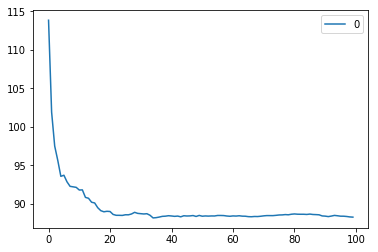

In [317]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

#### R2 KNN Regressor Plot

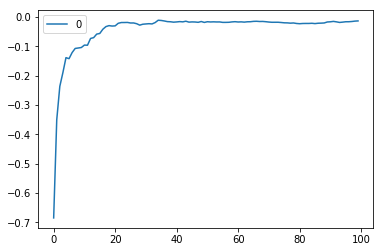

In [318]:
#plotting the rmse values against k values
curve = pd.DataFrame(r2_val) #elbow curve 
curve.plot()

#### Predicting Airbnb Prices in Seattle on test data set using KNN Regressor  

In [331]:

#predicting on the test set and creating submission file
predict_knn_reg_2 = model.predict(X_test)


In [332]:
knn_mean_sq_err_2 = mean_squared_error(y_test, predict_knn_reg_2)

knn_mean_sq_err_2 ** (1/2)

82.18296779756098

#### Grid Search on KNN Regressor

In [333]:
params = {'n_neighbors':[56,57,58,59,60,61,62,63,64,65]}

knn_reg = KNeighborsRegressor()

model_knn_reg = GridSearchCV(knn_reg, params, cv=5)
model_knn_reg.fit(X_train,y_train)
model_knn_reg.best_params_

{'n_neighbors': 64}

In [334]:
knn = KNeighborsClassifier(n_neighbors = k)



#### K = 64 - KNN Regressor Predictions

In [335]:
knn_pred_final = KNeighborsRegressor(n_neighbors = 64)
model_knn_reg.fit(X_train,y_train)
predict_knn_reg_final = model.predict(X_test)


In [336]:
knn_mean_sq_err_3 = mean_squared_error(y_test, predict_knn_reg_final)

rmse_knn_final = knn_mean_sq_err_3 ** (1/2)

rmse_knn_final

82.18296779756098

In [337]:
r2_knn_final = r2_score(y_test, predict_knn_reg_final )

r2_knn_final

-0.0020660251869613067